In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [36]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import re

# 데이터 호출 및 파악

In [37]:
df = pd.read_csv('./datasets/hate_speech_binary_dataset.csv', encoding='utf-8')
# df = df[['text', 'label']]
df = df.dropna()
df = df.reset_index(drop=True)

In [38]:
df.columns=['text','label']

In [39]:
df

,text,label
0,정말 재밌다 연기도 좋고 디카프리오 짱,1
1,심쿵심쿵 미치네요이수혁땜에 잠 못자겠어요ㅠ자꾸 아른거림ㅠ,1
2,하지만 이니후빨러들은 이런거 관심 하나도 없음,0
3,@착한아이임당 A4 용지 덮고?,0
4,"진짜 평점 믿으면 안된 다는 걸 현실로 보여주는 영화입니다. 네티즌,전문가 하나같이...",1
...,...,...
189990,원작을 읽을 때 이런 건 절대 영상화하기 힘들다고 생각했는데 벤휘쇼의 연기와 더불어...,1
189991,케석대 어깨 올라간거봐라 ㅋㅋ,0
189992,@김짜꾸 day and night\n\nround the clock\n\nwitho...,0
189993,로버트다우니주니어를 좋아해서 봤는데너무재밌게 봤던영화생각없이 볼때 딱좋음,1


In [40]:
def replace_space(sentence):
    new = "".join(["" if ch == " " else ch for ch in sentence])
    return new

In [41]:
df['text'] = df['text'].apply(replace_space)

In [42]:
df

,text,label
0,정말재밌다연기도좋고디카프리오짱,1
1,심쿵심쿵미치네요이수혁땜에잠못자겠어요ㅠ자꾸아른거림ㅠ,1
2,하지만이니후빨러들은이런거관심하나도없음,0
3,@착한아이임당A4용지덮고?,0
4,"진짜평점믿으면안된다는걸현실로보여주는영화입니다.네티즌,전문가하나같이영화에서예술성과철학...",1
...,...,...
189990,원작을읽을때이런건절대영상화하기힘들다고생각했는데벤휘쇼의연기와더불어나름잘표현해주었다.향...,1
189991,케석대어깨올라간거봐라ㅋㅋ,0
189992,@김짜꾸dayandnight\n\nroundtheclock\n\nwithoutabreak,0
189993,로버트다우니주니어를좋아해서봤는데너무재밌게봤던영화생각없이볼때딱좋음,1


In [43]:
def is_only_dots(s):
    return all(char == '.' for char in s)

In [44]:
def is_only_space(s):
    return all(char == ' ' for char in s)

In [45]:
def is_only_space_hangul(s):
    return all(ord(char) == 12644 for char in s)

In [46]:
df.shape

(189995, 2)

In [47]:
# dot만 포함하는 row 거거
df = df[~df['text'].apply(is_only_dots)]

In [48]:
df.shape

(189923, 2)

In [49]:
# dot만 포함하는 row 거거
df = df[~df['text'].apply(is_only_space)]

In [50]:
df.shape

(189923, 2)

In [51]:
df = df[~df['text'].apply(is_only_space_hangul)]

In [52]:
df.shape

(189922, 2)

In [53]:
df = df.reset_index(drop=True)

In [54]:
counts = df['label'].value_counts()
print(f'Normal speech counts :{counts[0]} ({counts[0]/len(df)*100:.2f}%)')
print(f'Hate speech counts :{counts[1]} ({counts[1]/len(df)*100:.2f}%)')


Normal speech counts :89992 (47.38%)
Hate speech counts :99930 (52.62%)


최대 길이 : 1419
최소 길이 : 1
리뷰의 평균 길이 : 31.724771221870032


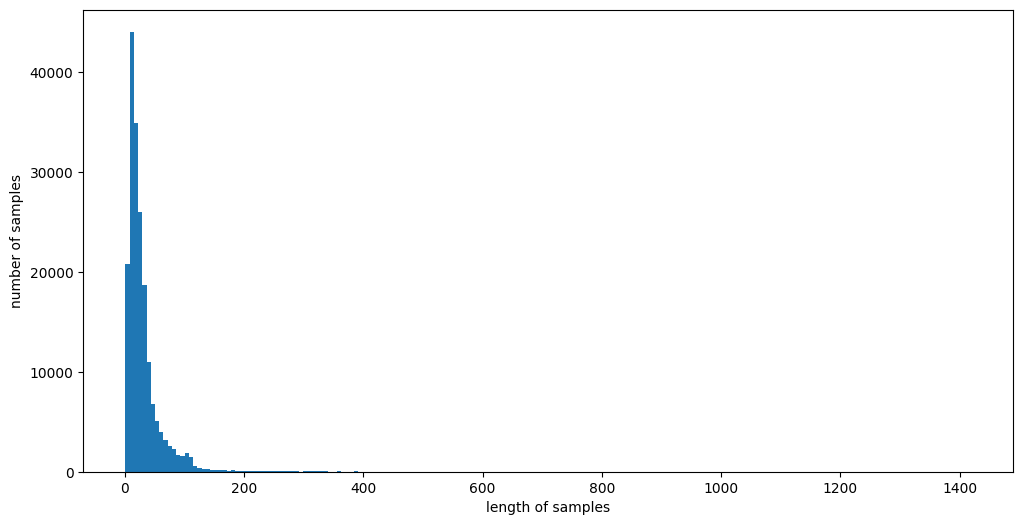

In [55]:
plt.figure(figsize=(12, 6))
print('최대 길이 :', max(len(text) for text in df['text']))
print('최소 길이 :', min(len(text) for text in df['text']))
print('리뷰의 평균 길이 :', sum(df['text'].str.len())/len(df))
plt.hist([len(text) for text in df['text']], bins=200)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [56]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [57]:
threshold = 50

In [58]:
below_threshold_len(threshold, df['text'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 85.3060730194501


In [59]:
# threshold보다 문장이 작으면 반복적으로 붙여주는 작업을 함
# threshold보다 문장이 길면 슬라이싱을 함
def add_cut_sentence(sentence, threshold):
    cut_list = []
    if len(sentence) >= threshold:
        cut_list = sentence[:threshold]
    else:
        while True:
            if len(cut_list) >= threshold:
                cut_list = cut_list[:threshold]
                break
            cut_list += sentence
    return "".join(cut_list)

In [60]:
# threshold보다 문장이 작으면 반복적으로 붙여주는 작업을 함
# threshold보다 문장이 길면 슬라이싱을 함
def cut_sentence(sentence, threshold):
    cut_list = []
    cut_list = sentence[:threshold]
    return cut_list

In [61]:
df['text'] = df['text'].apply(lambda text: add_cut_sentence(text, threshold))

In [62]:
# df['text'] = df['text'].apply(lambda text: cut_sentence(text, threshold))

In [63]:
df

,text,label
0,정말재밌다연기도좋고디카프리오짱정말재밌다연기도좋고디카프리오짱정말재밌다연기도좋고디카프리...,1
1,심쿵심쿵미치네요이수혁땜에잠못자겠어요ㅠ자꾸아른거림ㅠ심쿵심쿵미치네요이수혁땜에잠못자겠어요...,1
2,하지만이니후빨러들은이런거관심하나도없음하지만이니후빨러들은이런거관심하나도없음하지만이니후...,0
3,@착한아이임당A4용지덮고?@착한아이임당A4용지덮고?@착한아이임당A4용지덮고?@착한아...,0
4,"진짜평점믿으면안된다는걸현실로보여주는영화입니다.네티즌,전문가하나같이영화에서예술성과철학...",1
...,...,...
189917,원작을읽을때이런건절대영상화하기힘들다고생각했는데벤휘쇼의연기와더불어나름잘표현해주었다.향...,1
189918,케석대어깨올라간거봐라ㅋㅋ케석대어깨올라간거봐라ㅋㅋ케석대어깨올라간거봐라ㅋㅋ케석대어깨올라...,0
189919,@김짜꾸dayandnight\n\nroundtheclock\n\nwithoutabr...,0
189920,로버트다우니주니어를좋아해서봤는데너무재밌게봤던영화생각없이볼때딱좋음로버트다우니주니어를좋...,1


In [64]:
df.shape

(189922, 2)

# 이미지화

In [65]:
# 이미지로 변환하는 함수
def create_sentence_image(sentence, font_path, font_size, background_color=(0, 0, 0), text_color=(255, 255, 255)):
  sentence_split = sentence.split('\n')
  width = len(max(sentence_split, key=len)) # 길이가 가장 긴 리스트의 길이로 너비 결정
  height = len(sentence_split) # 개행으로 나눠진 리스트의 길이로 높이 결정

  image_width, image_height = (width*16), height*24  # 픽셀 사이즈 조정
  image = Image.new('RGB', (image_width, image_height), background_color)
  draw = ImageDraw.Draw(image)

  # 폰트 호출
  font = ImageFont.truetype(font_path, font_size)

  # Get the text size
  # text_width, text_height = draw.textlength(sentence, font=font)
  _, _, text_width, text_height = draw.textbbox((0, 0), sentence, font=font)

  # Calculate the position to center the text
  x = (image_width - text_width) // 2
  y = (image_height - text_height) // 2

  # Draw the letter on the image
  draw.text((x, y), sentence, font=font, fill=text_color)

  # Convert image to numpy array
  img_array = np.array(image)

  # Find the bounding box of non-background pixels
  non_background = np.where(img_array != background_color)
  top, left = np.min(non_background[0]), np.min(non_background[1])
  bottom, right = np.max(non_background[0]), np.max(non_background[1])

  # Crop the image
  cropped_image = image.crop((left, top, right+1, bottom+1))

  return np.array(cropped_image)

In [66]:
# 폰트 설정
font_path = "./utils/arial-unicode.ttf"
font_size = 12

In [67]:
text = "안녕하세요???? 테스트 데이터입니다............."
# text = df['text'][2]
sample = replace_space(text)
# sample = text
img = create_sentence_image(str(sample), font_path, font_size)
display(img)

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [113, 113, 113],
        [223, 223, 223],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 94,  94,  94],
        [207, 207, 207],
        [ 43,  43,  43],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [188, 188, 188],
        [ 52,  52,  52],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [188, 188, 188],
        [ 52,  52,  52],
        ...,
        [  0,   0,   0],
        [240, 240, 240],
        [ 68,  68,  68]],

       [[  0,   0,   0],
        [188, 188, 188],
        [255, 255, 255],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [68]:
print(f"Y axis max value: {img.shape[0]}")
print(f"X axis max value: {img.shape[1]}")

Y axis max value: 11
X axis max value: 237


# coordinates 추출

In [69]:
# convert image into coordinates
def get_coordinates(img):
  img_arr = np.array(img)
  coordinates = []
  for x in range(len(img_arr)):
    for y in range(len(img_arr[x])):
      if max(img_arr[x][y]) != 0:
        coordinates.append([y,x])
  return np.array(coordinates)

In [70]:
def extract_x_y(img_arr, coordinates):
  # x = np.array([point[0] for point in coordinates]) / len(img_arr[0])
  # y = np.array([point[1] for point in coordinates]) / len(img_arr)
  x = np.array([point[0] for point in coordinates])
  y = np.array([point[1] for point in coordinates])
  # y = 1-y
  return x, y

In [71]:
def draw_text(x, y):
  # plotting
  plt.scatter(x, y, color='blue')

  # Set plot title and labels
  plt.title('Coordinates for Sentence')
  plt.xlabel('X-axis')
  plt.ylabel('Y-axis')

  # Display plot
  plt.show()

In [72]:
coordinates = get_coordinates(img)

In [73]:
coordinates.shape

(965, 2)

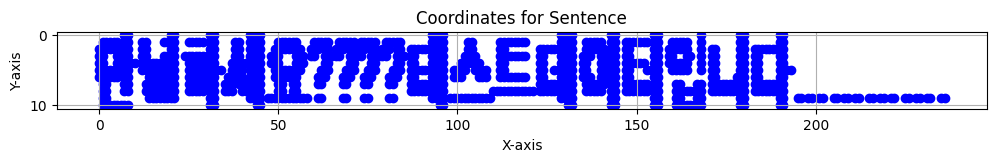

In [74]:
# plotting
import matplotlib.pyplot as plt

x, y = extract_x_y(img, coordinates)

plt.figure(figsize=(12, 1))
plt.scatter(x, y, color='blue')

# Set plot title and labels
plt.title('Coordinates for Sentence')
plt.gca().invert_yaxis()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)  # 그리드 추가

# Display plot
plt.show()

# 좌표값 정규화

In [75]:
def std_coordinates(data, max_x, max_y):
    standardized_data = np.zeros_like(data, dtype=float)
    standardized_data[:, 0] = data[:, 0] / max_x
    standardized_data[:, 1] = data[:, 1] / max_y
    return standardized_data

In [76]:
coordinates[300]

array([130,   3])

In [77]:
img.shape

(11, 237, 3)

In [78]:
std_coords = std_coordinates(coordinates, img.shape[1], img.shape[0])

In [79]:
std_coords.shape

(965, 2)

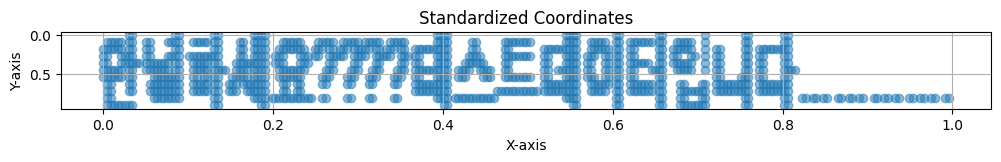

In [80]:
# 산점도 그리기
plt.figure(figsize=(12, 1))
plt.scatter(std_coords[:, 0], std_coords[:, 1], alpha=0.5)
plt.title('Standardized Coordinates')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().invert_yaxis()
# plt.xlim(0, 1)  # x축 범위를 0에서 1로 설정
# plt.ylim(0, 1)  # y축 범위를 0에서 1로 설정
plt.grid(True)  # 그리드 추가

# 플롯 표시
plt.show()

# 전처리

In [81]:
# 패딩
def pad_coords(coords, pad_size=3000):
    sorted_data = coords[coords[:, 0].argsort()]
    if len(sorted_data) >= pad_size:
        return sorted_data[:pad_size]        
    else:
        diff = pad_size - len(sorted_data)
        sorted_data = np.pad(sorted_data, ((0, diff), (0, 0)), mode='constant', constant_values=0)
    return sorted_data

In [82]:
data = []
# sorting and slicing
pad_size = 3500

for i in range(len(df)):
    # 이미지화
    text = df['text'][i]
    sample = replace_space(text)
    img = create_sentence_image(str(text), font_path, font_size)
    
    # 좌표 추출
    coordinates = get_coordinates(img)
    
    x_lim = img.shape[1]
    y_lim = img.shape[0]
    
    # 좌표 정규화
    std_coords = std_coordinates(coordinates, x_lim, y_lim)
    padded_coords = pad_coords(std_coords, pad_size)

    data.append(padded_coords)

    if i % 1000 == 0:
        print(i)
    
print("Preprocess complete")
print(len(data))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


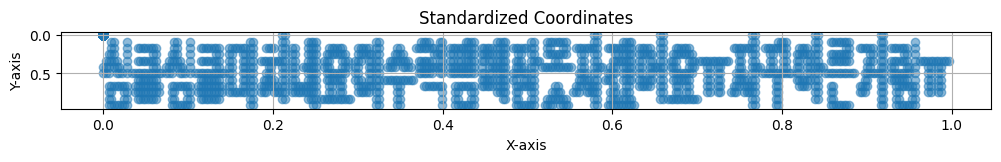

In [171]:
# 산점도 그리기
plt.figure(figsize=(12, 1))
plt.scatter(data[1][:, 0], data[1][:, 1], alpha=0.5)
plt.title('Standardized Coordinates')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().invert_yaxis()
# plt.xlim(0, 1)  # x축 범위를 0에서 1로 설정
# plt.ylim(0, 1)  # y축 범위를 0에서 1로 설정
plt.grid(True)  # 그리드 추가

# 플롯 표시
plt.show()

In [172]:
max_len = max(len(i) for i in data)
min_len = min(len(i) for i in data)
average = sum(len(i) for i in data) / len(data)

print("max length: ", max_len)
print("min length: ", min_len)
print("avg length: ", average)

max length:  3500
min length:  3500
avg length:  3500.0


# 정규화

In [83]:
np.array(data).shape

(189922, 3500, 2)

In [84]:
data = np.array(data)

In [85]:
data.shape

(189922, 3500, 2)

# 데이터 분할

In [86]:
# # 데이터 분할
x_train = data[:160000]
y_train = df[:160000]['label']

x_test = data[160000:]
y_test = df[160000:]['label']

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(160000, 3500, 2)
(160000,)
(29922, 3500, 2)
(29922,)


# 모델 설계

In [89]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model
model = models.Sequential([
    layers.Conv1D(64, 2, activation='relu', input_shape=(3500,2)),
    layers.Conv1D(128, 2, activation='relu', padding='same'),
    layers.MaxPooling1D(),
    layers.Conv1D(256, 2, activation='relu', padding='same'),
    layers.MaxPooling1D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [90]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 3499, 64)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 3499, 128)      │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 1749, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 1749, 256)      │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 874, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 223744)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    57,278,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,427,393 (219.07 MB)

 Trainable params: 57,427,393 (219.07 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [92]:
batch_size = 256
epochs = 5

# Train the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

# Evaluate the model
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1/5


I0000 00:00:1722989366.609906  278139 service.cc:146] XLA service 0x7fef7401d300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722989366.613263  278139 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-08-07 09:09:26.725302: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-07 09:09:26.996405: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


  3/563 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.5152 - loss: 1.5718  

I0000 00:00:1722989372.804903  278139 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


563/563 ━━━━━━━━━━━━━━━━━━━━ 42s 58ms/step - accuracy: 0.6267 - loss: 0.6729 - val_accuracy: 0.7231 - val_loss: 0.5150
Epoch 2/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 27s 47ms/step - accuracy: 0.7277 - loss: 0.5075 - val_accuracy: 0.7454 - val_loss: 0.4977
Epoch 3/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 27s 47ms/step - accuracy: 0.7464 - loss: 0.4805 - val_accuracy: 0.7519 - val_loss: 0.4768
Epoch 4/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 27s 47ms/step - accuracy: 0.7759 - loss: 0.4402 - val_accuracy: 0.7571 - val_loss: 0.4698
Epoch 5/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 27s 47ms/step - accuracy: 0.8229 - loss: 0.3729 - val_accuracy: 0.7384 - val_loss: 0.5018
Test loss: 0.5040799975395203
Test accuracy: 0.7407258749008179
